In [1]:
import os, json, wandb, torch, random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from monai import transforms, data
from monai.data import DataLoader, DistributedSampler
from monai.utils import set_determinism
from tqdm import tqdm
from monai.losses.ssim_loss import SSIMLoss
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import  PatchDiscriminator
import matplotlib.pyplot as plt
import torch.distributed as dist
from torch.utils.data import Dataset

/opt/conda/envs/pytorch/lib/python3.12/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/opt/conda/envs/pytorch/lib/python3.12/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [ ]:
class MRIDataset(Dataset):
    def downsample_mri_kspace(self, mri_image, downsampling_factor):
        """
        Downsamples an MRI image using k-space zero-filling.

        Args:
            mri_image (nibabel.Nifti1Image): The input MRI image as a Nifti1Image object.
            downsampling_factor (tuple): A tuple of integers specifying the downsampling
                                        factor along each spatial dimension (e.g., (2, 2, 1)
                                        for downsampling by 2 in the first two dimensions).
                                        The length of the tuple should match the number of
                                        spatial dimensions of the image.

        Returns:
            nibabel.Nifti1Image: The downsampled MRI image as a Nifti1Image object.
        """

        # Get the image data and affine transformation
        data = mri_image[0]

        # Get the spatial dimensions
        spatial_dims = data.shape[:len(downsampling_factor)]
        num_spatial_dims = len(spatial_dims)

        # Check if the downsampling factor is valid
        if len(downsampling_factor) != num_spatial_dims:
            raise ValueError(f"Downsampling factor length ({len(downsampling_factor)}) must match the number of spatial dimensions ({num_spatial_dims}).")
        for factor in downsampling_factor:
            if not isinstance(factor, int) or factor < 1:
                raise ValueError("Downsampling factors must be positive integers.")

        # Perform k-space transform
        k_space = np.fft.fftn(data, axes=range(num_spatial_dims))
        k_space_shifted = np.fft.fftshift(k_space, axes=range(num_spatial_dims))

        # Create a new k-space array with zero-filling
        new_k_space_shape = list(k_space_shifted.shape)

        # Determine the central portion to keep in k-space
        start_indices = []
        end_indices = []
        for i in range(num_spatial_dims):
            center = spatial_dims[i] // 2
            half_kept = (spatial_dims[i] // downsampling_factor[i]) // 2
            start_indices.append(center - half_kept)
            end_indices.append(center + (spatial_dims[i] // downsampling_factor[i]) - half_kept)
            new_k_space_shape[i] = spatial_dims[i] // downsampling_factor[i]

        # Place the central portion of the original k-space into the new (larger) array
        slices = tuple(slice(start, end) for start, end in zip(start_indices, end_indices))
        # downsampled_k_space_shifted[slices] = k_space_shifted[slices]
        downsampled_k_space_shifted = k_space_shifted[slices]

        # Inverse k-space transform to get the downsampled image
        downsampled_k_space = np.fft.ifftshift(downsampled_k_space_shifted, axes=range(num_spatial_dims))
        downsampled_data = np.fft.ifftn(downsampled_k_space, axes=range(num_spatial_dims)).real
        downsampled_data = downsampled_data[np.newaxis, ...]  # Add a new axis to match the original shape

        return downsampled_data

    def __init__(self, image_paths):
        self.image_paths = image_paths
        self.resample_factors = [(1, 1, 4), (1, 1, 2), (1, 4, 1), (1, 2, 1), (4, 1, 1), (2, 1, 1)]
        self.train_transform_1 = transforms.Compose([
            transforms.LoadImaged(keys=["file_name"]),
            transforms.CopyItemsd(keys=['file_name'], names=['image']),
            transforms.DeleteItemsd(keys=['file_name']),
            transforms.EnsureChannelFirstd(keys=["image"]),
            transforms.EnsureTyped(keys=["image"]),
            transforms.Orientationd(keys=["image"], axcodes="RAS"),
            transforms.ScaleIntensityRangePercentilesd(keys=["image"], lower=0.5, upper=99.5, b_min=0, b_max=1,clip=True ),
            transforms.Spacingd(keys=['image'],pixdim=(1,1,1),mode=3),
            transforms.ResizeWithPadOrCropd(keys=['image'],spatial_size=(240,240,160)),
            transforms.CopyItemsd(keys=['image'], names=['hi_res','low_res'], times=2),
            transforms.DeleteItemsd(keys=['image']),])
        self.train_transform_2 = transforms.Compose([
            transforms.Resized(keys=["low_res"], spatial_size=(240,240,160), mode="nearest"),
            # transforms.CropForegroundd(keys=['hi_res','low_res'], source_key="hi_res",allow_smaller=False),
            # transforms.RandSpatialCropd(keys=['hi_res','low_res'], roi_size=(64,64,64), random_size=False),
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        data = self.image_paths[idx]
        transformed_data = self.train_transform_1(data)
        # print(transformed_data['hi_res'].shape)
        transformed_data['low_res'] = self.downsample_mri_kspace(transformed_data['low_res'], random.choice(self.resample_factors))
        # transformed_data['low_res'] = self.downsample_mri_kspace(transformed_data['low_res'], (2, 1, 1))
        transformed_data = self.train_transform_2(transformed_data)
        return transformed_data

In [3]:
with open('json/train_files.json') as f:
    train_files = json.load(f)

In [4]:
train_ds = MRIDataset(train_files)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=False, num_workers=4, persistent_workers=False, sampler=None, collate_fn=None)

In [5]:
for data_batch in train_loader:
    temp = data_batch
    break

data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])
data shape torch.Size([240, 240, 160])


In [6]:
print(temp['low_res'].shape)
print(temp['hi_res'].shape)

torch.Size([4, 1, 240, 240, 160])
torch.Size([4, 1, 240, 240, 160])


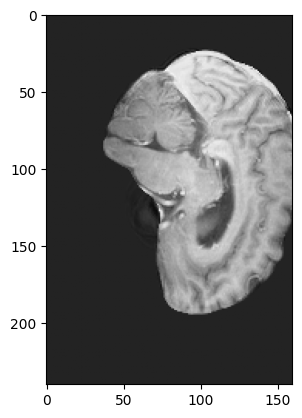

In [7]:
import matplotlib.pyplot as plt
plt.imshow(temp['low_res'][0,0,120,:,:].cpu().numpy(), cmap='gray')
plt.show()